# 資料分析的七個練習專案：累積個人作品集

> 練習專案一：兩百個國家、兩百年、四分鐘

[數聚點](https://www.datainpoint.com) | 郭耀仁 <yaojenkuo@datainpoint.com>

## 專案說明

## 資料視覺化的兩個經典案例

1. Hans Rosling's 200 Countries, 200 Years, 4 Minutes: <https://youtu.be/jbkSRLYSojo?si=5WkjOoiU_IPuKGsR>
2. Charles Minard's Napoleon's disastrous Russian campaign of 1812: <https://en.wikipedia.org/wiki/Charles_Joseph_Minard>

## 兩個案例之所以為經典

- 在短篇幅中涵蓋豐富資訊，但是精準傳達想表達的核心理念。
- 資料是多維度，呈現形式是二維的。
- 美觀。

## 如何復刻 Hans Rosling's 200 Countries, 200 Years, 4 Minutes

- 資料需求。
    - X 軸：人均 GDP
    - Y 軸：預期壽命。
    - 顏色：洲別。
    - 大小：人口數。
    - 時間軸：年份。
- 視覺化需求。
    - 概念驗證：`matplotlib.pyplot`
    - 成品：`plotly.express`

## 資料來源

## 來自 [gapminder.org](https://www.gapminder.org/data/) 的資料

- gapminder.org 基金會是由 Hans Rosling 與其家人共同創立的基金會，目的是透過統計資料的使用和理解，促進以事實為基礎的世界觀察。
- gapminder.org 提供不同來源與格式的世界統計資料：
    - Systema Globalis
    - [Fast Track](https://github.com/open-numbers/ddf--gapminder--fasttrack)
    - World Development Indicators

## 練習專案採用 [Fast Track](https://github.com/open-numbers/ddf--gapminder--fasttrack) 資料

- X 軸：人均 GDP <https://github.com/open-numbers/ddf--gapminder--fasttrack/blob/master/countries_etc_datapoints/ddf--datapoints--gdp_pcap--by--country--time.csv>
- Y 軸：預期壽命。<https://github.com/open-numbers/ddf--gapminder--fasttrack/blob/master/countries_etc_datapoints/ddf--datapoints--lex--by--country--time.csv>
- 顏色：洲別。<https://github.com/open-numbers/ddf--gapminder--fasttrack/blob/master/ddf--entities--geo--country.csv>
- 大小：人口數。<https://github.com/open-numbers/ddf--gapminder--fasttrack/blob/master/countries_etc_datapoints/ddf--datapoints--pop--by--country--time.csv>
- 時間軸：年份。

## 建立專案資料夾與環境

- 新增 `gapminder-clone` 資料夾。
- 將 [Fast Track](https://github.com/open-numbers/ddf--gapminder--fasttrack) 資料下載到專案資料夾中的 `data/`
- 使用 `conda` 建立專案環境。

```shell
conda create --name gapminder python=3.12
```

## 啟動環境與安裝模組的指令

```shell
(base) conda activate gapminder
(gapminder) conda install $module_name
(gapminder) pip install $module_name
```

## 以 `pandas` 載入 [Fast Track](https://github.com/open-numbers/ddf--gapminder--fasttrack) 資料

In [1]:
file_names = ["ddf--datapoints--gdp_pcap--by--country--time",
              "ddf--datapoints--lex--by--country--time",
              "ddf--datapoints--pop--by--country--time",
              "ddf--entities--geo--country"]
file_keys = ["gdp_pcap", "lex", "pop", "geo"]

In [2]:
import pandas as pd

df_dict = dict()
for file_name, file_key in zip(file_names, file_keys):
    file_path = f"data/{file_name}.csv"
    df = pd.read_csv(file_path)
    df_dict[file_key] = df

## 以 `sqlite3` 與 `pandas` 建立資料庫 `gapminder.db`

In [4]:
import sqlite3

connection = sqlite3.connect("data/gapminder.db")
for k, v in df_dict.items():
    v.to_sql(name=k, con=connection, index=False, if_exists="replace")
connection.close()

## 在 `gapminder.db` 建立一個檢視表 `plotting`

In [17]:
drop_view_sql = """
DROP VIEW IF EXISTS plotting;
"""
create_view_sql = """
CREATE VIEW plotting AS
SELECT gdp_pcap.country AS country_alpha3,
       geo.name AS country_name,
       gdp_pcap.time AS year,
       gdp_pcap.gdp_pcap AS gdp_per_capita,
       geo.world_4region AS continent,
       lex.lex AS life_expectancy
  FROM gdp_pcap
  JOIN geo
    ON gdp_pcap.country = geo.country
  JOIN lex
    ON gdp_pcap.country = lex.country AND
       gdp_pcap.time = lex.time
  JOIN pop
    ON gdp_pcap.country = pop.country AND
       gdp_pcap.time = pop.time
 WHERE gdp_pcap.time < 2024;
"""

In [16]:
connection = sqlite3.connect("data/gapminder.db")
cur = connection.cursor()
cur.execute(drop_view_sql)
cur.execute(create_view_sql)
connection.close()

## 整理程式碼為一個類別 `CreateGapminderDB`

```python
class CreateGapminderDB:
    def __init__(self):
        self.file_names = ["ddf--datapoints--gdp_pcap--by--country--time",
                           "ddf--datapoints--lex--by--country--time",
                           "ddf--datapoints--pop--by--country--time",
                           "ddf--entities--geo--country"]
        self.file_keys = ["gdp_pcap", "lex", "pop", "geo"]
    def import_as_dataframe(self):
        df_dict = dict()
        for file_name, file_key in zip(self.file_names, self.file_keys):
            file_path = f"data/{file_name}.csv"
            df = pd.read_csv(file_path)
            df_dict[file_key] = df
        return df_dict
```

```python
    def create_database(self):
        connection = sqlite3.connect("data/gapminder.db")
        df_dict = self.import_as_dataframe()
        for k, v in df_dict.items():
            v.to_sql(name=k, con=connection, index=False, if_exists="replace")
        drop_view_sql = """
        DROP VIEW IF EXISTS plotting;
        """
        create_view_sql = """
        CREATE VIEW plotting AS
        SELECT gdp_pcap.country AS country_alpha3,
               geo.name AS country_name,
               gdp_pcap.time AS year,
               gdp_pcap.gdp_pcap AS gdp_per_capita,
               geo.world_4region AS continent,
               lex.lex AS life_expectancy,
               pop.pop AS population
          FROM gdp_pcap
          JOIN geo
            ON gdp_pcap.country = geo.country
          JOIN lex
            ON gdp_pcap.country = lex.country AND
               gdp_pcap.time = lex.time
          JOIN pop
            ON gdp_pcap.country = pop.country AND
               gdp_pcap.time = pop.time
         WHERE gdp_pcap.time < 2024;
        """
        cur = connection.cursor()
        cur.execute(drop_view_sql)
        cur.execute(create_view_sql)
        connection.close()
```

## 檢查類別 `CreateGapminderDB` 能否順利運行

```python
create_gapminder_db = CreateGapminderDB()
create_gapminder_db.create_database()
```

## 完成後用 SQLiteStudio 檢視一下

## 概念驗證

## 從 `plotting` 檢視表選取所有的資料

In [8]:
connection = sqlite3.connect("data/gapminder.db")
plotting_df = pd.read_sql("""SELECT * FROM plotting;""", con=connection)
connection.close()

## 透過 `matplotlib` 模組繪製靜態圖

In [9]:
year_to_plot = 1800
subset_df = plotting_df[plotting_df["year"] == year_to_plot]
lex = subset_df["life_expectancy"].values
gdp_pcap = subset_df["gdp_per_capita"].values
cont = subset_df["continent"].values
color_map = {
    "asia": "r",
    "africa": "g",
    "europe": "b",
    "americas": "c"
}

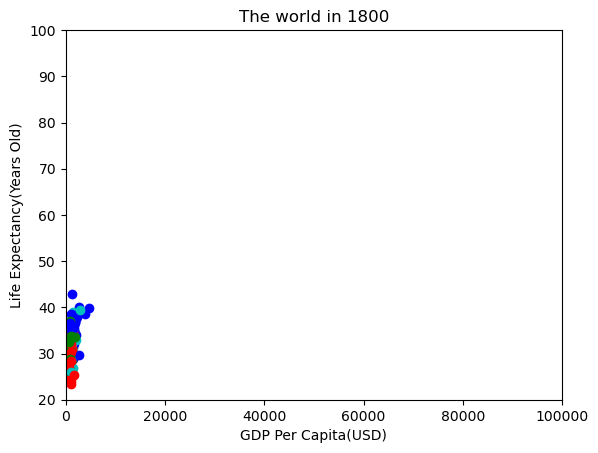

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for xi, yi, yri, ci in zip(gdp_pcap, lex, year, cont):
    ax.scatter(xi, yi, color=color_map[ci])
ax.set_title(f"The world in {year_to_plot}")
ax.set_xlabel("GDP Per Capita(USD)")
ax.set_ylabel("Life Expectancy(Years Old)")
ax.set_ylim(20, 100)
ax.set_xlim(0, 100000)
plt.show()

In [11]:
year_to_plot = 2023
subset_df = plotting_df[plotting_df["year"] == year_to_plot]
lex = subset_df["life_expectancy"].values
gdp_pcap = subset_df["gdp_per_capita"].values
cont = subset_df["continent"].values
color_map = {
    "asia": "r",
    "africa": "g",
    "europe": "b",
    "americas": "c"
}

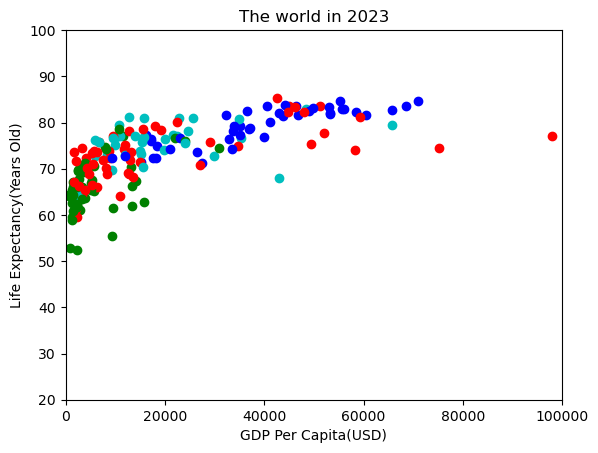

In [12]:
fig, ax = plt.subplots()
for xi, yi, yri, ci in zip(gdp_pcap, lex, year, cont):
    ax.scatter(xi, yi, color=color_map[ci])
ax.set_title(f"The world in {year_to_plot}")
ax.set_xlabel("GDP Per Capita(USD)")
ax.set_ylabel("Life Expectancy(Years Old)")
ax.set_ylim(20, 100)
ax.set_xlim(0, 100000)
plt.show()

## 透過 `matplotlib` 模組繪製動畫

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
def update_plot(year_to_plot: int):
    ax.clear()
    subset_df = plotting_df[plotting_df["year"] == year_to_plot]
    lex = subset_df["life_expectancy"].values
    gdp_pcap = subset_df["gdp_per_capita"].values
    cont = subset_df["continent"].values
    color_map = {
        "asia": "r",
        "africa": "g",
        "europe": "b",
        "americas": "c"
    }
    for xi, yi, yri, ci in zip(gdp_pcap, lex, year, cont):
        ax.scatter(xi, yi, color=color_map[ci])
    ax.set_title(f"The world in {year_to_plot}")
    ax.set_xlabel("GDP Per Capita(USD)")
    ax.set_ylabel("Life Expectancy(Years Old)")
    ax.set_ylim(20, 100)
    ax.set_xlim(0, 100000)

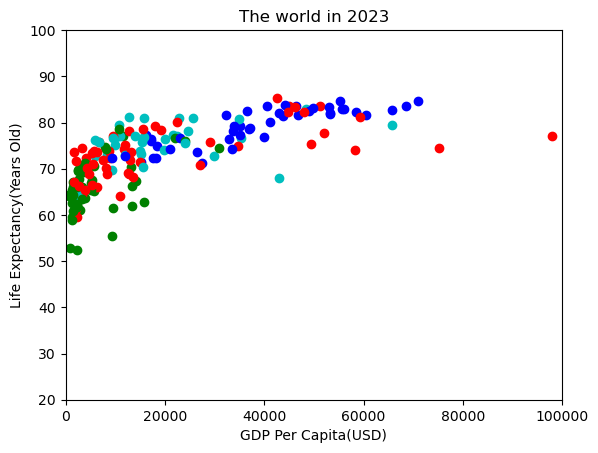

In [7]:
ani = animation.FuncAnimation(fig, update_plot, frames=range(2000, 2024), interval=10)
ani.save('animation.gif', fps=10)
plt.show()

## 成品

## 從 `plotting` 檢視表選取所有的資料

In [13]:
connection = sqlite3.connect("data/gapminder.db")
sql_query = """
SELECT *
  FROM plotting
 WHERE year < 2024;
"""
plotting_df = pd.read_sql(sql_query, con=connection)
connection.close()

## 透過 `plotly.express` 模組繪製動畫

In [20]:
import plotly.express as px

fig = px.scatter(plotting_df, x="gdp_per_capita", y="life_expectancy",
                 animation_frame="year", animation_group="country_name",
                 size="population", color="continent", hover_name="country_name", 
                 size_max=100, range_x=[100, 100000], range_y=[20, 100], log_x=True,
                 title="Gapminder Clone 1800-2023")
fig.write_html("gapminder_clone.html", auto_open=True)

## 延伸優化